# Globoko učenje, vaje 2 - rekurenčne nevronske mreže

Spoznali bomo modeliranje časovnih vrst s pomočjo rekurenčnih nevronskih mrež. Za vajo bomo sami implementirali rekurečno celico, GRU celico ter LSTM celico. Na koncu bomo pogledali še, kako lahko uporabimo pytorch-eve implementacije teh celic.

In [18]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt


## 1. Priprava podatkov

Delali bomo s časovno vrsto ene spremenljivke. Za začetek uporabimo funkcijo sinus v N točkah. Podatke razdelimo na učno in testno množico, pri časovnih vrstah pa je pomembno, da se vedno učimo na preteklosti in napovedujemo prihodnost - podatkov torej ne smemo premešati! 

Učni primer za rekurenčno mrežo bo zaporedje dolžine M. Napiši funkcjo generiraj_zaporedja, ki sprejme časovno vrsto ter parameter M in zgenerira N-M zaporedij dolžine M (torej prvo od indeksa 0 do indeksa M, drugo od 1 do M+1, itd.). 

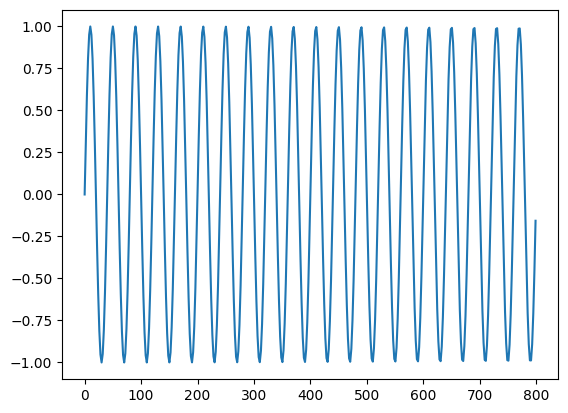

In [19]:
x = torch.linspace(0,799,400)
y = torch.sin(x*2*np.pi/40) 

test_size = 100
train_data = y[:-test_size]
test_data = y[-test_size:]

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        sequences.append((data[i:i+seq_length], data[i+seq_length:i+seq_length+1]))
    return sequences

seq_length = 20
train_sequences = create_sequences(train_data, seq_length)

plt.plot(x,y)

## 2. RNN celica

### 2.1 RNN celica
Implementirajmo svojo rekurečno celico myRNNCell ter mrežo myRNN, ki jo uporablja. Celica bo računala skrito stanje po enačbi
$$h_t = \tanh{(W_{ih}x_t + U_{hh}h_{t-1} + b_{ih} + b_{hh})},$$
kjer je $x_t$ vhod (v našem primeru skalar), $h_{t-1}$ skrito stanje iz prejšnje iteracije (vektor izbrane dolžine), $W_{ih}, W{hh}, b_{ih}, b_{hh}$ pa so parametri linearne plasti nevronske mreže. Formulacijo lahko malo poenostavimo tako, da na vsaki iteraciji združimo vektorja $x_t$ in $h_{t-1}$ (recimo **torch.cat**) ter uporabljamo eno samo mrežo za združen vektor. 

Koristno je napisati še funkcjo, ki postavi vrednosti skritega stanja na 0.

Dopolni!

In [20]:
class myRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(myRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh = nn.Tanh()

        self.hidden = torch.zeros(hidden_size)

    def forward(self, x):
        combined = torch.cat((x, self.hidden))
        self.hidden = self.tanh(self.i2h(combined))
        return self.hidden
    
    def reset_hidden(self):
        self.hidden = torch.zeros(self.hidden_size)


### 2.2. Mreža z RNN celico

Zdaj napišimo še nevronsko mrežo, ki uporablja našo novo celico. Poleg RNN celice mreži dodaj še linearno plast, ki na podlagi skritega stanja napove $x_{t+1}$. Forward funkcija mreže bo na vsakem koraku prejela zaporedje kot vhod, zato mora implementirati zanko, ki elemente zaporedja poda RNN celici eno po eno, vrača pa $x_{t+1}$.

In [21]:
class myRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn_cell = myRNNCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def reset_hidden(self):
        self.rnn_cell.reset_hidden()

    def forward(self, x):
        output = []
        for t in range(x.shape[0]):
            h = self.rnn_cell(x[t].view(-1))
            output += [self.output_layer(h)]

        output = torch.stack(output)
        return output[-1]

### 2.3. Učna zanka

Zdaj potrebujemo še učno zanko. Najprej ustvarimo model, funkcijo napake (tokrat kar kvadratna napaka - nn.MSELoss) ter optimizator (kot zadnjič, torch.optim.Adam). Spiši učno zanko, ki mora zdaj na vsakem epohu izvesti še zanko po podzaporedjih. Pred vsakim zaporedjem postavi skrito stanje na 0.

In [22]:
model = myRNN(1, 32, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
for epoch in range(epochs):
    print("Epoch ", epoch)
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        model.reset_hidden()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        if i%100 == 0:
            print(f'i: {i:03d}, Loss: {loss:.4f}')




Epoch  0
i: 000, Loss: 0.0484
i: 100, Loss: 0.0705
i: 200, Loss: 0.1027
Epoch  1
i: 000, Loss: 0.0786
i: 100, Loss: 0.0712
i: 200, Loss: 0.0047
Epoch  2
i: 000, Loss: 0.0001
i: 100, Loss: 0.0004
i: 200, Loss: 0.0011
Epoch  3
i: 000, Loss: 0.0012
i: 100, Loss: 0.0013
i: 200, Loss: 0.0012
Epoch  4
i: 000, Loss: 0.0012
i: 100, Loss: 0.0011
i: 200, Loss: 0.0010
Epoch  5
i: 000, Loss: 0.0010
i: 100, Loss: 0.0009
i: 200, Loss: 0.0008
Epoch  6
i: 000, Loss: 0.0008
i: 100, Loss: 0.0008
i: 200, Loss: 0.0007
Epoch  7
i: 000, Loss: 0.0007
i: 100, Loss: 0.0006
i: 200, Loss: 0.0005
Epoch  8
i: 000, Loss: 0.0005
i: 100, Loss: 0.0005
i: 200, Loss: 0.0004
Epoch  9
i: 000, Loss: 0.0004
i: 100, Loss: 0.0004
i: 200, Loss: 0.0003


### 2.4. Evaluacija

Da model evaluiramo, moramo spet iterirati skozi vse sekvence ter shranjevati napovedi. Ker napovedujemo numerično spremenljivko, uporabimo $R^2$ metriko.

0.9953860096318771


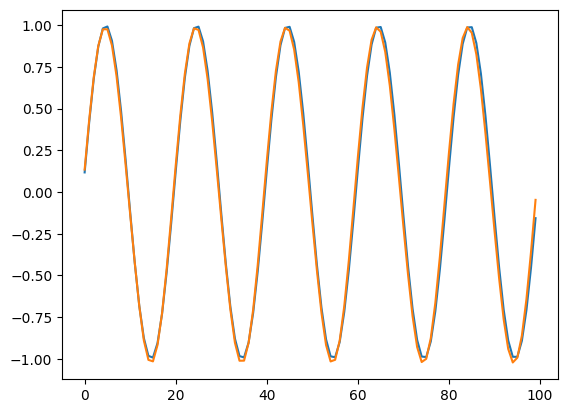

In [23]:
test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        model.reset_hidden()
        res = model(seq)
        test_inputs.append(res.item())

from sklearn.metrics import r2_score
print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()

### 2.5 Hiperparametri

Rezultati verjetno niso najboljši, saj je delovanje rekurenčne mreže močno odvisno od hiperparametrov. Poskusi najti konfiguracijo, ki deluje dobro. Najpomembnejši parametri za variirati so dolžina sekvenc, število skritih stanj, learning rate ter število epohov.

## 3. GRU celica

### 3.1 GRU celica

je nagradnja RNN celice, ki se dinamično odloča, kaj naj pozabi in kaj naj si zapomni. Implementiraj GRU celico! Za osnovo lahko vzameš RNN celico iz 2.1 ter si pomagaš s prosojnicami s predavanj. 

In [24]:
class myGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(myGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.tanh = nn.Tanh()
        self.sig = nn.Sigmoid()

        self.reset_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.update_gate = nn.Linear(input_size + hidden_size, hidden_size)

        self.hidden = torch.zeros(hidden_size)

    def forward(self, x):
        combined = torch.cat((x, self.hidden))

        rt = self.sig(self.reset_gate(combined))
        combined2 = torch.cat((x, rt*self.hidden))
        ht_hat = self.tanh(self.i2h(combined2))
        zt = self.sig(self.update_gate(combined))
        ht = zt*ht_hat + (1-zt)*self.hidden

        self.hidden = ht.detach()

        return self.hidden
    
    def reset_hidden(self):
        self.hidden = torch.zeros(self.hidden_size)

### 3.2 Mreža z GRU celico

Podobno kot v 2.2, pripravi mrežo, ki uporablja GRU celico.

In [25]:
class myGRUnet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myGRUnet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = myGRUCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def reset_hidden(self):
        self.gru_cell.reset_hidden()

    def forward(self, x):
        output = []
        for t in range(x.shape[0]):
            h = self.gru_cell(x[t].view(-1))
            output += [self.output_layer(h)]

        output = torch.stack(output)
        return output[-1]

### 3.3 Učna zanka, evaluacija, hiperparametri

Spiši učno zanko, podobno kot v 2.3, ter jo evaluiraj. Najdi konfiguracijo hiperparametrov, ki deluje dobro.

In [26]:
model = myGRUnet(1, 32, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for epoch in range(epochs):
    print("Epoch ", epoch)
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        model.reset_hidden()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        if i%100 == 0:
            print(f'i: {i:03d}, Loss: {loss:.4f}')

Epoch  0
i: 000, Loss: 0.0034
i: 100, Loss: 0.0002
i: 200, Loss: 0.0013
Epoch  1
i: 000, Loss: 0.0012
i: 100, Loss: 0.0002
i: 200, Loss: 0.0035
Epoch  2
i: 000, Loss: 0.0001
i: 100, Loss: 0.0013
i: 200, Loss: 0.0065
Epoch  3
i: 000, Loss: 0.0002
i: 100, Loss: 0.0033
i: 200, Loss: 0.0102
Epoch  4
i: 000, Loss: 0.0012
i: 100, Loss: 0.0061
i: 200, Loss: 0.0145
Epoch  5
i: 000, Loss: 0.0031
i: 100, Loss: 0.0095
i: 200, Loss: 0.0193
Epoch  6
i: 000, Loss: 0.0057
i: 100, Loss: 0.0135
i: 200, Loss: 0.0245
Epoch  7
i: 000, Loss: 0.0089
i: 100, Loss: 0.0180
i: 200, Loss: 0.0299
Epoch  8
i: 000, Loss: 0.0127
i: 100, Loss: 0.0229
i: 200, Loss: 0.0357
Epoch  9
i: 000, Loss: 0.0169
i: 100, Loss: 0.0280
i: 200, Loss: 0.0416
Epoch  10
i: 000, Loss: 0.0215
i: 100, Loss: 0.0335
i: 200, Loss: 0.0478
Epoch  11
i: 000, Loss: 0.0263
i: 100, Loss: 0.0391
i: 200, Loss: 0.0540
Epoch  12
i: 000, Loss: 0.0315
i: 100, Loss: 0.0449
i: 200, Loss: 0.0603
Epoch  13
i: 000, Loss: 0.0369
i: 100, Loss: 0.0509
i: 200, L

-0.019606538432061615


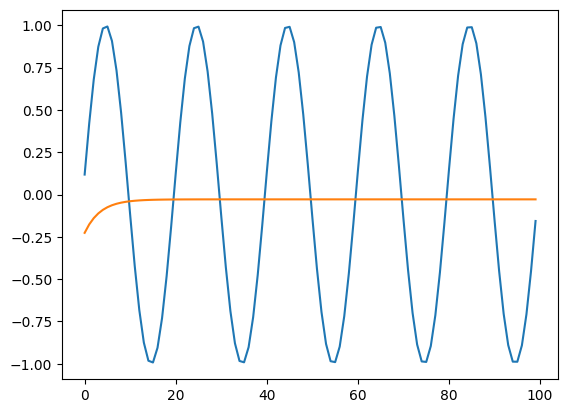

In [27]:
test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        model.reset_hidden()
        res = model(seq)
        test_inputs.append(res.item())

from sklearn.metrics import r2_score
print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()

## 4. LSTM celica

### 4.1 LSTM celica

izboljša delovanje rekurenčne mreže za naloge, ko je potrebna obravnava daljše zgodovine. To doseže tako z dodatnim skritim stanjem, ki ima vlogo dolgoročnega spomina. Na podlagi GRU celice ter prosojnic s predavanj implementiraj LSTM celico!

In [28]:
class myLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(myLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.tanh = nn.Tanh()
        self.sig = nn.Sigmoid()

        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.exit_gate = nn.Linear(input_size + hidden_size, hidden_size)

        self.hidden = torch.zeros(hidden_size)
        self.cell = torch.zeros(hidden_size)

    def forward(self, x):
        combined = torch.cat((x, self.hidden))

        ft = self.sig(self.forget_gate(combined))
        it = self.sig(self.input_gate(combined))
        ct_hat = self.tanh(self.i2h(combined))
        ct = ft*self.cell + it*ct_hat
        ot = self.sig(self.exit_gate(combined))
        ht = ot * self.tanh(ct)

        self.cell = ct.detach()
        self.hidden = ht.detach()

        return ht
    
    def reset_hidden(self):
        self.hidden = torch.zeros(self.hidden_size)
        self.cell = torch.zeros(self.hidden_size)

class myLSTMnet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myLSTMnet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru_cell = myLSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def reset_hidden(self):
        self.gru_cell.reset_hidden()

    def forward(self, x):
        output = []
        for t in range(x.shape[0]):
            h = self.gru_cell(x[t].view(-1))
            output += [self.output_layer(h)]

        output = torch.stack(output)
        return output[-1]

In [29]:
model = myLSTMnet(1, 32, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for epoch in range(epochs):
    print("Epoch ", epoch)
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        model.reset_hidden()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f'i: {i:03d}, Loss: {loss:.4f}')

Epoch  0
i: 000, Loss: 0.0087
i: 100, Loss: 0.0187
i: 200, Loss: 0.0351
Epoch  1
i: 000, Loss: 0.0165
i: 100, Loss: 0.0333
i: 200, Loss: 0.0566
Epoch  2
i: 000, Loss: 0.0365
i: 100, Loss: 0.0632
i: 200, Loss: 0.0971
Epoch  3
i: 000, Loss: 0.0754
i: 100, Loss: 0.1113
i: 200, Loss: 0.1506
Epoch  4
i: 000, Loss: 0.1242
i: 100, Loss: 0.1598
i: 200, Loss: 0.1947
Epoch  5
i: 000, Loss: 0.1630
i: 100, Loss: 0.1919
i: 200, Loss: 0.2184
Epoch  6
i: 000, Loss: 0.1844
i: 100, Loss: 0.2053
i: 200, Loss: 0.2236
Epoch  7
i: 000, Loss: 0.1901
i: 100, Loss: 0.2038
i: 200, Loss: 0.2149
Epoch  8
i: 000, Loss: 0.1839
i: 100, Loss: 0.1915
i: 200, Loss: 0.1969
Epoch  9
i: 000, Loss: 0.1692
i: 100, Loss: 0.1722
i: 200, Loss: 0.1733
Epoch  10
i: 000, Loss: 0.1494
i: 100, Loss: 0.1489
i: 200, Loss: 0.1469
Epoch  11
i: 000, Loss: 0.1268
i: 100, Loss: 0.1238
i: 200, Loss: 0.1196
Epoch  12
i: 000, Loss: 0.1031
i: 100, Loss: 0.0985
i: 200, Loss: 0.0929
Epoch  13
i: 000, Loss: 0.0798
i: 100, Loss: 0.0742
i: 200, L

0.8717240007198301


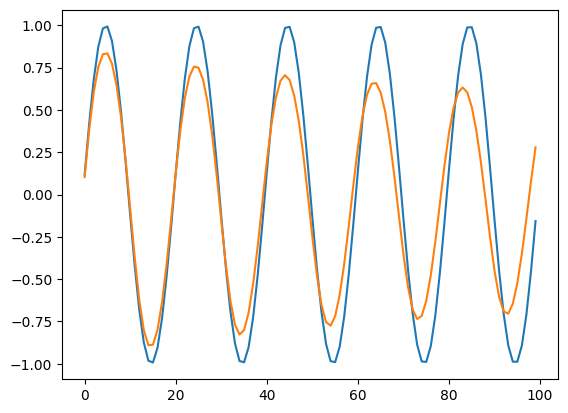

In [30]:
test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        model.reset_hidden()
        res = model(seq)
        test_inputs.append(res.item())

from sklearn.metrics import r2_score
print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()

## 5. Težji podatki

Preizkusi rekurenčne nevronske mreže še na težjih podatkih z dolgoročno odvisnostjo. Recimo:


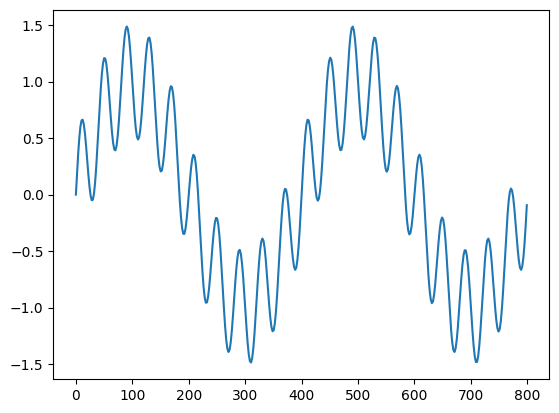

In [31]:
x = torch.linspace(0,799,400)
y = 0.5*torch.sin(x*2*np.pi/40) + torch.sin(x*2*np.pi/400)

plt.plot(x,y)

## 6. Boljše implementacije

Naša "domača" implementacija sicer približno deluje, a manjka ji veliko podrobnosti: možnosti več plasti, učenje v "batchih", dropout plasti, itd. Preizkusi še katero od pytorchevih implementacij: torch.nn.RNN, torch.nn.GRU, torch.nn.LSTM. Za primer:

i: 000, Loss: 0.0329
i: 100, Loss: 0.0372
i: 200, Loss: 0.0030
i: 000, Loss: 0.0201
i: 100, Loss: 0.0007
i: 200, Loss: 0.0001
i: 000, Loss: 0.0060
i: 100, Loss: 0.0488
i: 200, Loss: 0.0205
i: 000, Loss: 0.0034
i: 100, Loss: 0.0014
i: 200, Loss: 0.0001
i: 000, Loss: 0.0106
i: 100, Loss: 0.0053
i: 200, Loss: 0.0016
i: 000, Loss: 0.0018
i: 100, Loss: 0.0022
i: 200, Loss: 0.0022
i: 000, Loss: 0.0115
i: 100, Loss: 0.0120
i: 200, Loss: 0.0082
i: 000, Loss: 0.0017
i: 100, Loss: 0.0011
i: 200, Loss: 0.0002
i: 000, Loss: 0.0000
i: 100, Loss: 0.0009
i: 200, Loss: 0.0027
i: 000, Loss: 0.0078
i: 100, Loss: 0.0074
i: 200, Loss: 0.0031


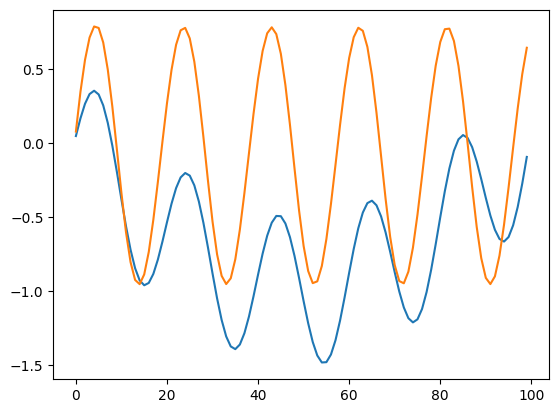

In [32]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x.view(len(x), 1, -1))
        x = self.fc(x.view(len(x), -1))
        return x[-1]



model = RNN(1, 32, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

for epoch in range(epochs):
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f'i: {i:03d}, Loss: {loss:.4f}')

test_inputs = train_data[-seq_length:].tolist()
model = model.eval()

for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size))
        test_inputs.append(model(seq).item())

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()